<b>Day 9: Implement a basic Autoencoder using TensorFlow to compress and reconstruct images. Visualize the original and reconstructed outputs. Use Convolutional Layers, add Noise to Input Images for Denoising Autoencoder, add a Bottleneck Visualization, train on Fashion MNIST, add Reconstruction Loss Graph and Early Stopping<b>

<b>PART 1: Basic Autoencoder to Compress & Reconstruct Images<b>


In [1]:
#Step 1: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist


In [2]:
#Step 2: Load and Normalize Fashion MNIST
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension (for CNN compatibility)
x_train = np.expand_dims(x_train, -1)  # shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)


In [3]:
# Step 3: Define a Basic Autoencoder
def build_basic_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Flatten()(input_img)
    x = layers.Dense(64, activation='relu')(x)
    bottleneck = layers.Dense(32, activation='relu')(x)  # Compressed representation

    # Decoder
    x = layers.Dense(64, activation='relu')(bottleneck)
    x = layers.Dense(28 * 28, activation='sigmoid')(x)
    output_img = layers.Reshape((28, 28, 1))(x)

    # Autoencoder model
    autoencoder = models.Model(input_img, output_img)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder



In [4]:
#Step 4: Train the Autoencoder
autoencoder = build_basic_autoencoder()

history = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.4774 - val_loss: 0.3225
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3160 - val_loss: 0.3071
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3028 - val_loss: 0.3013
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2983 - val_loss: 0.2996
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2952 - val_loss: 0.2956
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2924 - val_loss: 0.2935
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2918 - val_loss: 0.2918
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2898 - val_loss: 0.2904
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2874 - val_loss: 0.2893
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2867 - val_loss: 0.2885
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2863 - val_loss: 0.2874
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


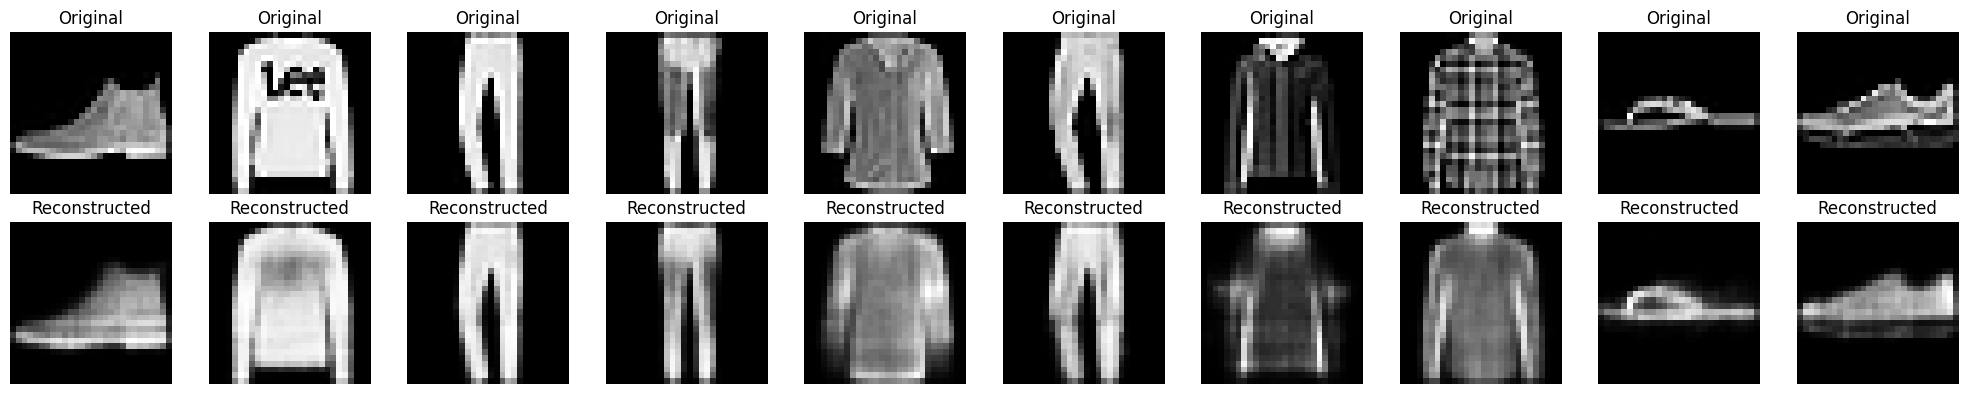

In [5]:
#Step 5: Visualize Original vs Reconstructed Images
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


<b>PART 1 Summary<b>

We loaded the Fashion MNIST dataset and normalized the images.

We created a basic autoencoder using fully connected layers to compress the images into a 32-dimensional vector and reconstruct them.

We trained the autoencoder to minimize reconstruction loss using binary crossentropy.

Finally, we visualized the original images and their reconstructed versions, and saw that the autoencoder learned to reconstruct key features like shapes and outlines.

<b>PART 2: Denoising Autoencoder with CNN, Noise, Bottleneck Visualization, and EarlyStopping
<b>

In [9]:
#Step 1: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA


In [11]:
#Step 2: Load and Normalize Fashion MNIST + Add Noise
# Load dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Expand dims for CNN
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Add Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [12]:
#Step 3: Define CNN-Based Denoising Autoencoder
def build_denoising_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    bottleneck = layers.MaxPooling2D((2, 2), padding='same')(x)  # 7x7x16

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(bottleneck)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder and encoder model
    autoencoder = models.Model(input_img, decoded)
    encoder = models.Model(input_img, bottleneck)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder, encoder


In [14]:
#Step 4: Train with EarlyStopping
autoencoder, encoder = build_denoising_autoencoder()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - loss: 0.4120 - val_loss: 0.3150
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3114 - val_loss: 0.3085
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3057 - val_loss: 0.3055
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3023 - val_loss: 0.3037
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3008 - val_loss: 0.3019
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.2996 - val_loss: 0.3007
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.2989 - val_loss: 0.3001
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.2975 - val_loss: 0.2992
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 0.2966 - val_loss: 0.2988
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.2969 - val_loss: 0.2980
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.2954 - val_loss: 0.2975
Epoch 12/50
469/469 ━━━━━━━━━━

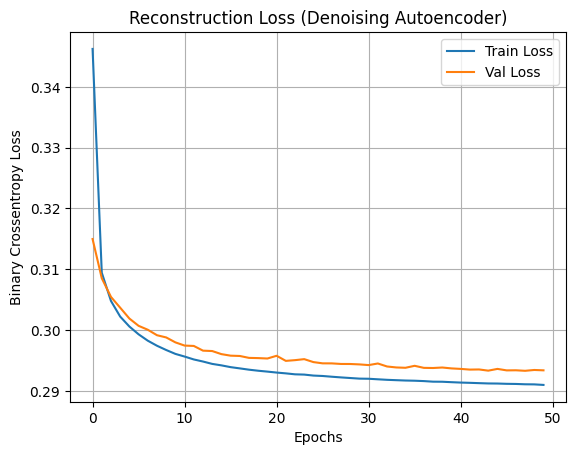

In [15]:
#Step 5: Plot Reconstruction Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Reconstruction Loss (Denoising Autoencoder)")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy Loss")
plt.legend()
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


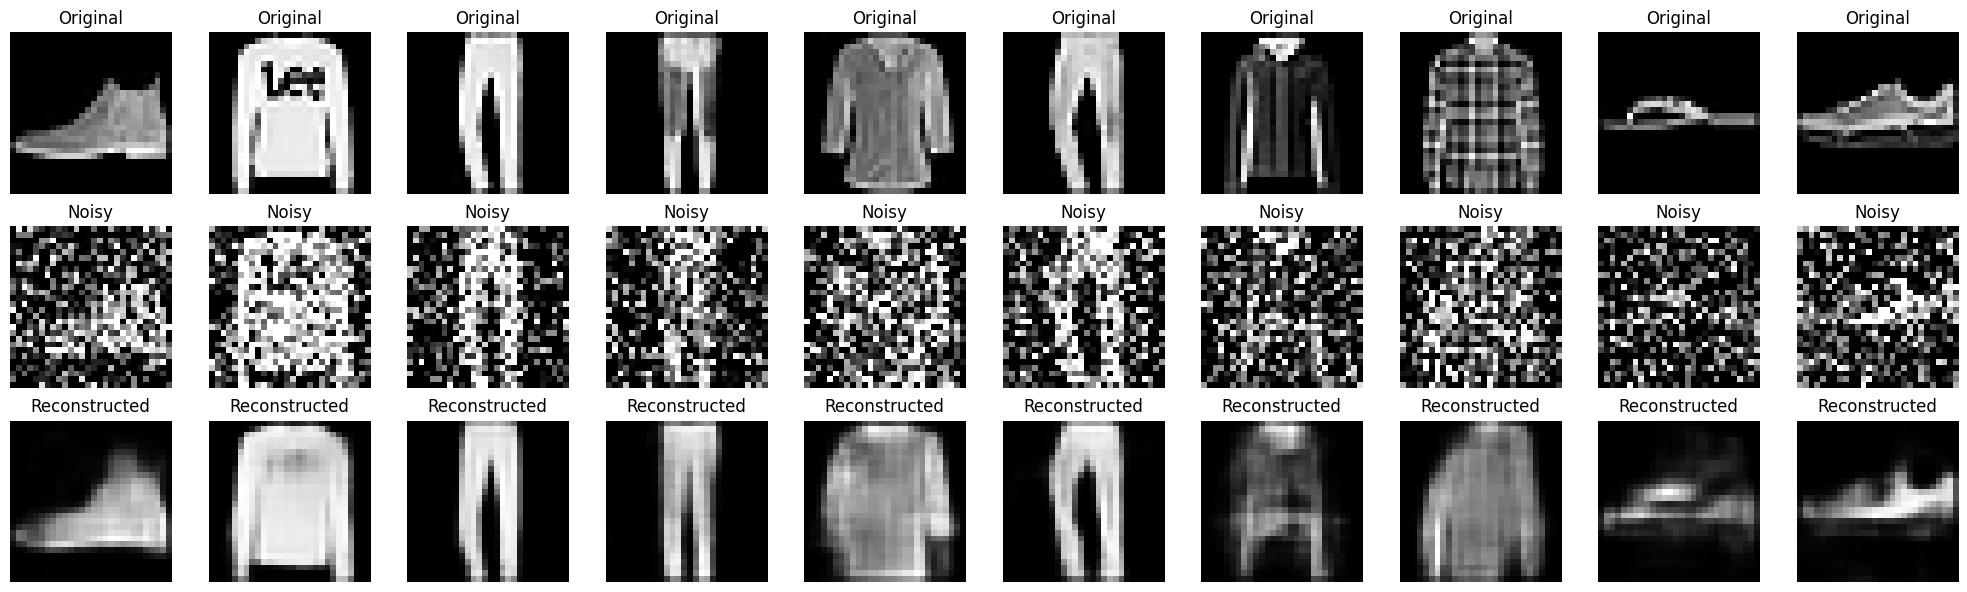

In [16]:
#Step 6: Visualize Original, Noisy & Reconstructed Images
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


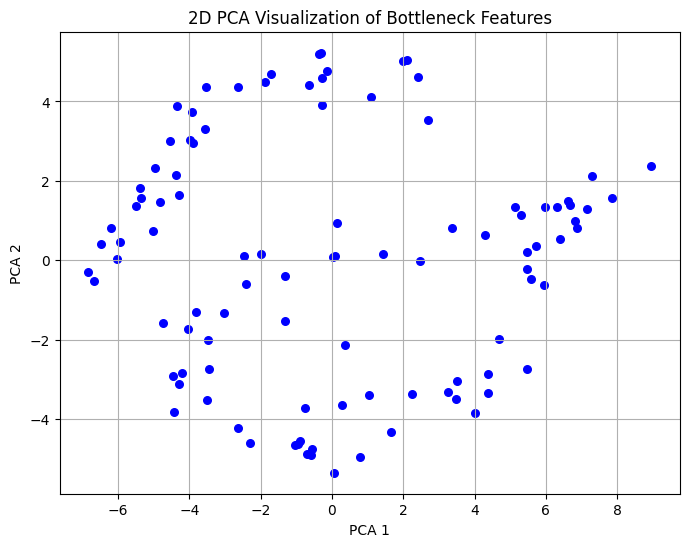

In [17]:
#Step 7: Visualize Bottleneck Features with PCA
# Get bottleneck for 100 samples
bottlenecks = encoder.predict(x_test_noisy[:100])  # Shape: (100, 7, 7, 16)

# Flatten each to 1D
flat_bottlenecks = bottlenecks.reshape(100, -1)

# Reduce to 2D
pca = PCA(n_components=2)
bottleneck_2d = pca.fit_transform(flat_bottlenecks)

# Plot the 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(bottleneck_2d[:, 0], bottleneck_2d[:, 1], c='blue', s=30)
plt.title("2D PCA Visualization of Bottleneck Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


<b>PART 2 Summary<b>

We built a CNN-based Denoising Autoencoder that learns to reconstruct clean images from noisy ones.

We added Gaussian noise to Fashion MNIST input images and trained the model to recover the original.

We used EarlyStopping to prevent overfitting by monitoring validation loss.

We plotted the loss curve to understand training behavior.

We visualized the original, noisy, and reconstructed images to verify the model’s output.

Finally, we used PCA to reduce the bottleneck features into 2D for visualization of the learned compressed representation.

